In [1]:
import time
start_time = time.time()

In [2]:
import logging
from pathlib import Path

import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import scipy.stats as stats
from scipy.stats import multivariate_normal as mvn

from dask.distributed import Client

import dcor

from stein_thinning.thinning import thin_gf

import lotka_volterra
import utils.caching
from utils.caching import cached, cached_batch, subscriptable
from utils.ksd import calculate_ksd
from utils.parallel import apply_along_axis_parallel, get_map_parallel
from utils.paths import FIGURES_PATH, GENERATED_DATA_PATH
from utils.plotting import centered_subplots, highlight_points, plot_paths, plot_sample_thinned, plot_traces
from utils.sampling import to_arviz

In [3]:
logging.basicConfig()
logging.getLogger(utils.caching.__name__).setLevel(logging.DEBUG)

In [4]:
import nest_asyncio
nest_asyncio.apply()

In [5]:
figures_path = FIGURES_PATH

Directory where results of expensive calculations will be stored:

In [6]:
utils.caching.cache_dir = GENERATED_DATA_PATH

In [7]:
recalculate = False  # True => perform expensive calculations, False => use stored results
save_data = recalculate

We create a Dask client in order to parallelise calculations where possible:

In [8]:
client = Client(processes=True, threads_per_worker=4, n_workers=4, memory_limit='2GB')
client

/home/artem/Study/KCL/ST50 Project/code/.venv/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35645 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:35645/status,
Dashboard: http://127.0.0.1:35645/status,Workers: 4
Total threads: 16,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42741,Workers: 4
Dashboard: http://127.0.0.1:35645/status,Total threads: 16
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:33753,Total threads: 4
Dashboard: http://127.0.0.1:43569/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:40875,


In [9]:
map_parallel = get_map_parallel(client)

Input parameters

In [10]:
n_chains = len(lotka_volterra.theta_inits)

In [11]:
titles = [f'$\\theta^{{(0)}} = ({theta[0]}, {theta[1]}, {theta[2]}, {theta[3]})$' for theta in lotka_volterra.theta_inits]
var_labels = [f'$\\log \\theta_{i + 1}$' for i in range(lotka_volterra.d)]

Read-only input datasets:

In [12]:
@subscriptable(n=n_chains)
@cached_batch(item_type=np.ndarray, read_only=True)
def rw_samples() -> list[np.ndarray]:
    raise NotImplemented

In [13]:
@subscriptable(n=n_chains)
@cached_batch(item_type=np.ndarray, read_only=True)
def rw_thinned_idx() -> list[np.ndarray]:
    raise NotImplemented

In [14]:
@subscriptable(n=n_chains)
@cached_batch(item_type=np.ndarray, read_only=True)
def validation_hmc_samples() -> list[np.ndarray]:
    raise NotImplemented

In [15]:
validation_sample = np.concatenate(validation_hmc_samples, axis=0)

DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_0.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_1
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_2
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_3
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_3.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_4
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_4.npy


# Gradient-free Stein thinning

In [16]:
n_points_calculate = 10_000
n_points_thinned = 20
n_points_display = 20

We recalculate the (unnormalised) log target density for all samples. Note that in principle we could have stored it during the MCMC run rather than recalculating it.

In [17]:
@subscriptable(n=len(lotka_volterra.theta_inits))
@cached(recalculate=recalculate, persist=True)
def rw_log_p(i: int) -> np.ndarray:
    return parallelise_for_unique(log_target_density, rw_samples[i])

In [18]:
@subscriptable(n=len(lotka_volterra.theta_inits))
@cached(recalculate=recalculate, persist=True)
def hmc_log_p(i: int) -> np.ndarray:
    return parallelise_for_unique(log_target_density, hmc_samples[i])

## Full sample

### Elliptic distributions

In [19]:
i = 0
sample = rw_samples[i]
sample_cov = np.cov(sample, rowvar=False, ddof=lotka_volterra.d)
rescale_matrix = np.linalg.inv(scipy.linalg.sqrtm(sample_cov))
sample_rescaled = np.einsum('kj,ij->ik', rescale_matrix, sample)

DEBUG:utils.caching:Reading from disk cache: rw_samples_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_samples_0.npy


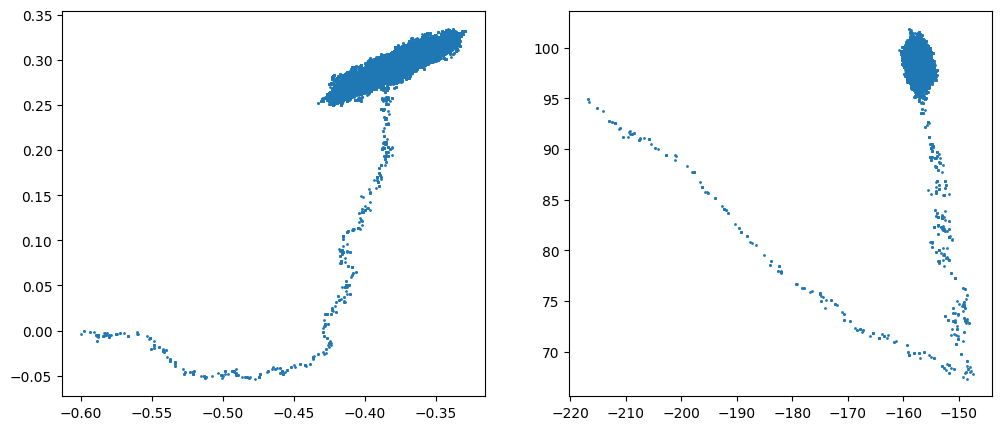

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(sample[:, 0], sample[:, 1], s=1);
axs[1].scatter(sample_rescaled[:, 0], sample_rescaled[:, 1], s=1);

DEBUG:utils.caching:Reading from disk cache: rw_log_p_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_log_p_0.npy
/home/artem/Study/KCL/ST50 Project/code/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/artem/Study/KCL/ST50 Project/code/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


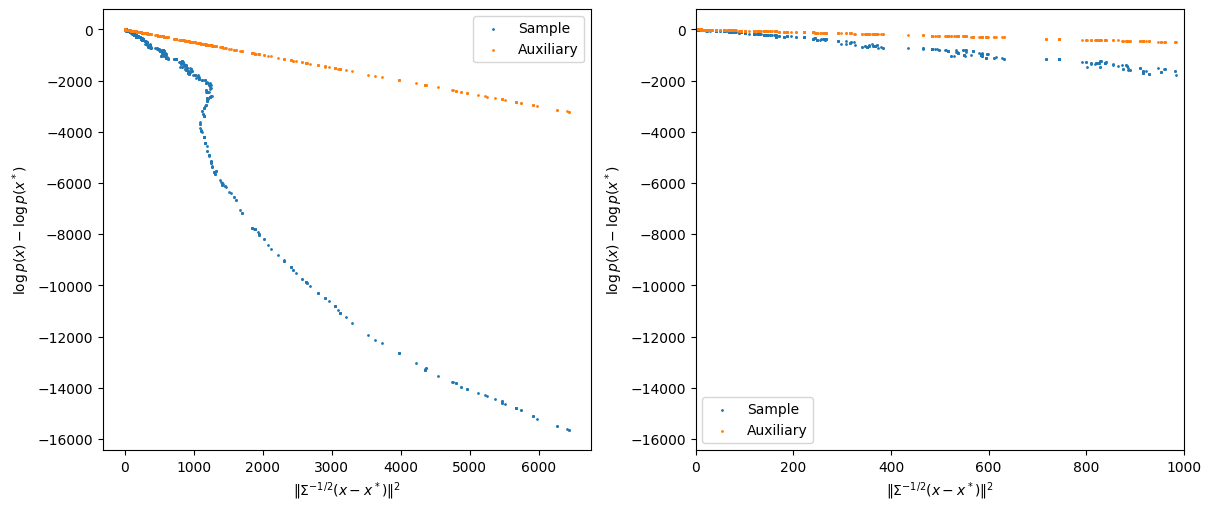

In [21]:
ref_idx = np.argmax(rw_log_p[i])
dists = cdist(sample_rescaled[ref_idx].reshape(1, -1), sample_rescaled).squeeze()
prob_diff = rw_log_p[i] - rw_log_p[i][ref_idx]

log_p_t = stats.multivariate_normal.logpdf(sample, mean=sample[ref_idx], cov=sample_cov)
prob_diff_t = log_p_t - log_p_t[ref_idx]

fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
axs[0].scatter(dists ** 2, prob_diff, s=1, label='Sample');
axs[0].scatter(dists ** 2, prob_diff_t, s=1, label='Auxiliary');
axs[0].set_xlabel('$\\|\\Sigma^{-1/2}(x - x^*) \\|^2$');
axs[0].set_ylabel('$\\log p(x) - \\log p(x^*)$');
axs[0].legend();

axs[1].scatter(dists ** 2, prob_diff, s=1, label='Sample');
axs[1].scatter(dists ** 2, prob_diff_t, s=1, label='Auxiliary');
axs[1].set_xlabel('$\\|\\Sigma^{-1/2}(x - x^*) \\|^2$');
axs[1].set_ylabel('$\\log p(x) - \\log p(x^*)$');
axs[1].set_xlim([0, 1000]);
axs[1].legend();

In [22]:
prob_diff_t

array([-3.21811660e+03, -3.21811660e+03, -3.20271497e+03, ...,
       -5.17925766e-01, -5.17925766e-01, -5.17925766e-01])

Notebook execution took:

In [23]:
time.time() - start_time

45.595638036727905